In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import statsmodels.api as sm
import os.path
import pickle

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

dataDetailsSheet = "Plan2"

In [2]:
utils = importr("MARSS")

# Data

## Regressors

In [3]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

In [4]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


,BZGDINDX Index,BZGDGNDI Index,BZGDFNCE Index,BZIPTLYo Index,BZUETOTN Index,BFOETTOD Index,MPMIBRMA Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZEASA INDEX,OEBRD003 INDEX,BZGDYOY% Index,BZGDQOQ Index,BZIPTLSA Index,BRLFUNRT Index,BFOETTSA Index,BZPIIPCY Index,BZRTRETM Index,BZJCTOTS Index
2017-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.loc[data.index[-1]].notnull().any()

True

### Select Sample 

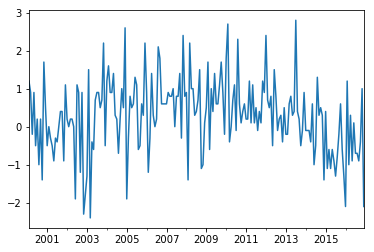

In [23]:
# data["BZRTRETM Index"].dropna().plot()

In [ ]:
gdpTicker = "BZGDYOY% Index"
listOfCols = [
    "BZGDYOY% Index",
#     "BZGDGNDI Index",
#     "BZGDFNCE Index",
    "BZIPTLSA Index",
    "MPMIBRMA Index",
    "BFOETTSA Index",
    "BZREELHT Index",
    "BZPIIPCY Index",
    "BZPIIPCM Index",
    "BZEXTOT$ Index",
    "BZTBBALY INDEX",
    "BZBXPBCM INDEX",
    "BZRTFBSA INDEX",
    "BZFGCCSA INDEX",
    "ibov index",
    "CL1 Comdty",
    "BCSWLPD CURNCY",
    "bcswfpd curncy",
    "BZMOTRFB INDEX",
    "BZJCTOTS Index",
    "BZEASA INDEX",
    "OEBRD003 INDEX",
    "BZRTRETM Index",
]
data = data[listOfCols]

In [ ]:
data.index.min()

In [ ]:
data.index.max()

### Transformations


In [ ]:
data.columns

In [ ]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet,)
transf.set_index("Code",inplace=True)

In [ ]:
for s in transf.index[transf["Log"]==True]:
    if s in data.columns:
        data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    if s in data.columns:
        print(s)
        data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    if s in data.columns:
        data[s] = data[s].diff(3)

In [ ]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Standardize


In [ ]:
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

### Stationarity

In [ ]:
# For now we'll drop quarterly series
# data.drop("BZGDGNDI Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("ibov index",axis=1,inplace=True)
# data.drop("CL1 Comdty",axis=1,inplace=True)
# data.drop("BCSWLPD CURNCY",axis=1,inplace=True)
# data.drop("bcswfpd curncy",axis=1,inplace=True)
# data.drop("BZEXTOT$ Index",axis=1,inplace=True)
# data.drop("BZTBBALY INDEX",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)

In [ ]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

# Dimensions

In [ ]:
dataQ = data[[gdpTicker]]
data.drop(gdpTicker,axis=1,inplace=True)

In [ ]:
T = data.shape[0]
T

In [ ]:
n = (data.columns | dataQ.columns).shape[0]
n

In [ ]:
nm = (data.columns).shape[0]
nm

In [ ]:
nq = (dataQ.columns).shape[0]
nq

In [ ]:
m = 5 + nm + 5 * nq
m

# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [ ]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [ ]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

In [ ]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)


In [ ]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

In [ ]:
# trying to impose restriction described in p 13-14 about identifying the model
Z.iloc[0,0] = 1
Z

## B Matrix

$B$ matrix is $m \times m$

In [ ]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

## Q Matrix

$Q_t$ is $m \times m$


In [ ]:
u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)
u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

In [ ]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]
Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

In [ ]:
Q

# Estimation without initial values

In [ ]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [ ]:
B.shape

In [ ]:
Z.shape

In [ ]:
y.shape

In [ ]:
Q.shape

In [ ]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n

# print(dim(Zi))
# Zi=matrix(Zi,n,m)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)

# print(dim(Zi))
# print(dim(Bi))
# print(dim(Qi))


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

# kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
# # kemfit = MARSS(yi, model=model.gen)

# # states = kemfit$states
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")

In [ ]:
print(dt.datetime.now())

# Initial Values

## PCA

In [ ]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

In [ ]:
components.set_index(y.transpose().index,inplace=True)
components.shape

In [ ]:
pd.DataFrame(components).plot()

## OLS for $\Lambda$ estimation

In [ ]:
data.head()

In [ ]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [ ]:
coefList = []
for s in data.columns:
    print(s)
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

In [ ]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [ ]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


In [ ]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

# Estimation With Initial Values

In [ ]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)

# Next two lines are only useful when the restriction is effective
Z0 = Z0 * (1/Z0.iloc[0,0]) 
Z0.drop(0,axis=0,inplace=True)

Z0

In [ ]:
x0i = np.zeros((m,1))
x0i[0,0] = components[0][0]
x0i = pd.DataFrame(x0i)
x0i

In [ ]:
Z0i = Z0.as_matrix().T.flatten()

In [ ]:
x0i = x0i.as_matrix().flatten()

In [ ]:
def runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,maxit):
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
prediction = predict(kemfit,n.ahead=10,se.fit=FALSE)
print(attributes(prediction))

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
#     dic = {}
#     dic[]'vintage'} = yi
    return robjects.r.prediction

In [ ]:
# pred = runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,5)

In [ ]:
# robjects.r['states1']
# robjects.r('attributes(prediction)')

In [ ]:
# robjects.r('print(prediction$method)')

In [ ]:
print(dt.datetime.now())

In [ ]:
# iters = [20,50,100,150,300,500,1000]
# # iters = [20,50,100,150]
# # iters = [20,50,100]
# stateslist = []
# for i in iters:
#     stateslist.append(runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,i))
#     print("done {maxiters}".format(maxiters=i))
#     print(dt.datetime.now())

In [ ]:
print(dt.datetime.now())

* x0 - Done
* normalizar as séries antes - fazer o check. data.mean e etc
* Initial MC - Bug

In [ ]:
# finalList = []
# for state in stateslist: 
#     finalList.append(pd.DataFrame(state).T)
# # stateslist[0]

## Check convergence

In [ ]:
def runModel2(Zi,Bi,Qi,y,n,m,Z0i,x0i,maxit):
    yi = y.T.as_matrix()
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
states2 = kemfit$ytT
kfit = print(kemfit)

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
    dic = {}
    dic['vintage' ]= y
    dic['states'] = pd.DataFrame(robjects.r.states1).T
    dic['prediction'] = pd.DataFrame(robjects.r('print(kemfit,what=\'ytT\')')).T
    dic['prediction'].index = y.index
    dic['prediction'].columns = y.columns
    dic['message'] = robjects.r.kfit
    return dic

In [ ]:
# listOfIters = [3, 5, 10, 30, 50, 100, 150,500,1000]
# # For Each pubdate
# listOfResultsConv = {}
# for iterN in listOfIters:
#     listOfResultsConv[iterN] = runModel2(Zi,Bi,Qi,y.T,n,m,Z0i,x0i,iterN)
    
# pickle.dump(listOfResultsConv, open(".\\Pickles\\Convergence.pickle", "wb"))

In [ ]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[150]['states'].T.loc[0])).hist()

In [ ]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[150]['states'].T.loc[0])).describe()

In [ ]:
# (listOfResultsConv[150]['states'].T.loc[0]).describe()

## Stylised Calendar

In [ ]:
yn = y.T
calendar = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet)
calendar = calendar[["Code","PubLag"]]
calendar.set_index("Code",inplace=True)

In [ ]:
# Goal Create publicationDates as another index on the DF

newDfs = []

# For each Series
for serie in yn.columns:
#     Create new df
    newDf = pd.DataFrame(yn[serie])
    newDf.reset_index(inplace=True)
    cols = list(newDf.columns)
    cols[0] = "refDate"
    newDf.columns = cols
    newDf["pubDate"] = newDf["refDate"] + dt.timedelta(int(calendar.loc[serie]))
    newDf.set_index(["refDate","pubDate"],inplace=True)
    newDfs.append(newDf)

yn = pd.concat(newDfs,axis=1)
yn = yn.groupby(level="refDate").fillna(method='ffill')

In [ ]:
# Goal: create stylised calendar for all info
pubDates = yn.index.get_level_values("pubDate").unique().sort_values()

In [ ]:
np.where(pubDates==dt.datetime(2014,5,1))

# Loop !

In [ ]:
maxiter = 300

In [ ]:
print(dt.datetime.now())

In [ ]:
def loadDf(pubDate):
    filename = ".\\Pickles\\" + pubDate.strftime('%Y-%m-%d') + ".pickle"
    return pickle.load(open(filename, "rb"))

In [ ]:
# For Each pubdate
listOfResults = {}
for pubDate in pubDates[5:]:
#     print(pubDate)
    cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
    cutY = cutY.reindex(y.T.index)
    filename = ".\\Pickles\\" + pubDate.strftime('%Y-%m-%d') + ".pickle"
    if os.path.exists(filename):
#         print("Exists")
#         listOfResults[pubDate] = pickle.load(open(filename, "rb"))
#         print("Loaded")
        None
    else:
        print(pubDate)
#         print("Does not exist")
        listOfResults[pubDate] = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)
#         listOfResults[pubDate].to_pickle(filename)
        pickle.dump(listOfResults[pubDate], open(filename, "wb"))
#         print("Dumped")
#     print("Loop Finished")
    
# Still have to find a way to locate everytime a given series enters the dataset    

In [ ]:
print(dt.datetime.now())

Notes:
   
* BCB reports YoY so we have to analise YoY

# Charts

## RMSFE chart

We'll get GDP dates and infer from ``listOfResults``'s keys which vintage corresponds to -X from the GDP pubDate 

So if I want -9, for each GDP published I'll find the -9 vintage and calculate the prediction error

In [ ]:
#  Find GDP's publication dates
gdp = yn[gdpTicker]
# .groupby(level="refDate",group_keys=True).last()

gdp = gdp[~gdp.isnull()]

gdpDates = gdp.index.get_level_values("refDate")
# gdpDates

In [ ]:
# vintages = pd.Series(list(listOfResults.keys())).sort_values().reset_index(drop=True)
vintages = pubDates[5:]
# vintages

In [ ]:
# vintagesOfInterest = {}
# vintagesOfInterest[pubDates[8]]= vintages[(vintages - pubDates[8])<= dt.timedelta(-9)].max()


In [ ]:
listOfAxis = [-30, -20, -10, 0, 10, 20, 30]
listOfAxis = range(-200,70)
listOfAxis = range(-70,70,10)
# listOfAxis = [-30]
# listOfAxis = np.arange(-70,70,10).tolist()

In [ ]:
rmsfe = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    for gdpDate in gdpDates[5:]:
        vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
        actualGdp = gdp.groupby(level="refDate").last()
        actualGdp = actualGdp.loc[gdpDate]
        
        # Loaded Version
#         forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction'][gdpTicker]
        #Load Version
        forecast = loadDf(vintagesOfInterest[gdpDate])['prediction'][gdpTicker]
        
        forecast = forecast.loc[gdpDate]
        tempList.append((forecast-actualGdp)**2)
    rmsfe[sieve] = tempList

#     rmsfe[sieve] = 

rmsfe = pd.DataFrame(rmsfe).T
nowcastRmsfe = rmsfe.mean(axis=1)

In [ ]:
rmsfe.mean(axis=1).plot.bar()

### Load BCB Expectation

In [ ]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)  # this will never fail
    return next_month - dt.timedelta(days=next_month.day)

In [ ]:
bcb = pd.read_pickle("BCB.pickle")

In [ ]:
bcb.head()

In [ ]:
# bcb["RefDate"] = bcb.index.get_level_values(0)
# bcb["Date"] = bcb.index.get_level_values(1)
bcb = bcb.reset_index()

In [ ]:
def subDate(row):
    return row["Date"] - row["ReferenceDate"]

bcb["TimeDelta"] = bcb.apply(subDate, axis=1)
bcb["ReferenceDate"] = bcb["ReferenceDate"].apply(last_day_of_month)
bcb = bcb.set_index(["ReferenceDate","TimeDelta"])
bcb.tail()  

In [ ]:
# list(bcb.index.get_level_values(0).unique())

In [ ]:
bcb.loc[gdpDate].loc[dt.timedelta(sieve):].iloc[-1]

In [ ]:
rmsfeBcb = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    for gdpDate in gdpDates[5:]:
        if gdpDate in list(bcb.index.get_level_values(0).unique()):
            vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
            actualGdp = gdp.groupby(level="refDate").last()
            actualGdp = actualGdp.loc[gdpDate]

            forecast = bcb.loc[gdpDate].loc[dt.timedelta(sieve):].iloc[-1]["BCB_Nowcast"]
#             forecast = forecast.loc[gdpDate]
            tempList.append((forecast-actualGdp)**2)
#             print("aqui")
    rmsfeBcb[sieve] = tempList

#     rmsfe[sieve] = 

rmsfeBcb = pd.DataFrame(rmsfeBcb).T
bcbRmsfe = rmsfeBcb.mean(axis=1)

In [ ]:
bcbRmsfe

In [ ]:
mu = data.mean()
sigma = data.std()

In [ ]:
val = gdp.groupby(level="refDate").last().loc[dt.datetime(2010,3,31)]
(val + mu[gdpTicker]) * sigma[gdpTicker]
# gdpTicker

In [ ]:
bcb.groupby(level="ReferenceDate").last().loc[dt.datetime(2010,3,31)]

In [ ]:
bcb.loc[dt.datetime(2010,3,31)].iloc[160:200]

## Actual vs Prediction chart

In [ ]:
actual = gdp.groupby(level="refDate").last()

In [ ]:
# at 0 date
sieve = 50
vintagesOfInterest = {}
tempDir = {}
for gdpDate in gdpDates[5:]:
    vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
    # Loaded Version
#     forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction'][gdpTicker]
    # Load version
    forecast = loadDf(vintagesOfInterest[gdpDate])['prediction'][gdpTicker]
    
    forecast = forecast.loc[gdpDate]
    
    tempDir[gdpDate] = forecast

predict = pd.Series(tempDir)


In [ ]:
(predict-actual).plot()

In [ ]:
(pd.concat([actual,predict],axis=1)).plot()

In [ ]:
vintagesOfInterest[dt.datetime(2016,11,29)]

In [ ]:
listOfResults[vintagesOfInterest[dt.datetime(2016,11,29)]]['prediction']

In [ ]:
# WHAT WE WILL DO: Always pass a full calendar (even if full of NaNs) 
# and NaN everything after the cut calendar
pubDate = pubDates[1000]
cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
cutY = cutY.reindex(y.T.index)
tr = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)


In [ ]:
tr['prediction'].columns

In [ ]:
gdpPred = tr['prediction'][gdpTicker]
gdp = yn.groupby(level="refDate").last()[gdpTicker]

gdpPred = gdpPred[~gdp.isnull()]
gdp = gdp[~gdp.isnull()]

In [ ]:
(gdpPred-gdp)

In [ ]:
(tr['prediction'][gdpTicker] - yn.groupby(level="refDate").last()[gdpTicker]).plot()

In [ ]:
x = robjects.r('print(kemfit,what=\'ytT\')')

In [ ]:
pd.DataFrame(x).T.plot()

In [ ]:
y.T.shape

In [ ]:
robjects.r['states2']

In [ ]:
ls[0]

In [ ]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n,Z0i,x0i -o states,states1


# Zi=matrix(Zi,n,m)
# x0i=matrix(x0i,m,1)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)


# # Z0i=matrix(Z0i,n,1)
# Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

# # print(dim(Z0i))
# # print(dim(Zi))
# # print(dim(Bi))
# # print(dim(Qi))
# # print(x0i)

# print("START")

# # model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero"
# #                ,U="zero"
# #                ,R="diagonal and unequal")


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
#                ,x0=x0i
# #                ,x0="zero"
#                ,U="zero"
#                ,R="diagonal and equal")


# inits = list(Z=Z0i,x0=0)
# # print(Z0i)
# # print(Zi)
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
# #                                                 conv.test.slope.tol=0.00001,
# #                                                 abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=300
# #                                                 conv.test.slope.tol=0.3
# #                                                 abstol=0.5, 
# #                                                 allow.degen=TRUE
# #                                                 MCInit=TRUE,
# #                                                 numInits=100,
# #                                                 numInitSteps=20
#                                                            ))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=30))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,fit=TRUE)
# # kemfit = MARSS(yi, model=model.gen,fit=FALSE)

# # print(kemfit$par$Z)
# states1 = kemfit$states
# states = print(kemfit)
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")